# Retrieval-Augmented Generation (RAG) Pipeline

This notebook demonstrates the setup and implementation of a Retrieval-Augmented Generation (RAG) pipeline using LangChain, Hugging Face models, and Groq API. The RAG pipeline combines retrieval-based methods with generative models to answer queries based on a given context. The Rag is used to develop a system that, for each natural language question in the BIRD benchmark, identifies 
the Source Tables (STs) and attributes (SAs) that contain data relevant to answering the question; 
results are evaluated against the BIRD (mini-dev) ground truth computing the overall recall, precision, and F1-score for detected STs and SAs. 

## Setup and Dependencies

First, we import the necessary libraries and set up the environment.

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
import os
from groq import Groq
from langchain_groq import ChatGroq
from transformers import AutoModelForCausalLM, AutoTokenizer,pipeline
import torch
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain.schema import StrOutputParser
from langchain.retrievers import BM25Retriever, EnsembleRetriever
import pandas as pd
from typing import List
from langchain_core.runnables import RunnableParallel
import time
from tqdm import tqdm 

# Set up the LLM
llm used for this project: 
<ul>
<li>llama-3.1-8b-instant: accessed through API,  Llama 3.1 is an auto-regressive language model that uses an optimized transformer architecture with 8 bilion parameters.</li>
<ul>

## local setup

In [ ]:
# Load the model and tokenizer from your HDD
save_directory = "filepath" #use the filepath to your model's location
model = AutoModelForCausalLM.from_pretrained(save_directory)
tokenizer = AutoTokenizer.from_pretrained(save_directory)

# Move the model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

### Create a Hugging Face Pipeline

We create a Hugging Face pipeline for text generation using the loaded model and tokenizer.

In [ ]:
# Create a Hugging Face pipeline
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    #temperature=0,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

### Wrap the Pipeline in LangChain's HuggingFacePipeline

We wrap the Hugging Face pipeline in LangChain's `HuggingFacePipeline` to integrate it with the LangChain framework.

In [ ]:
# Wrap the pipeline in LangChain's HuggingFacePipeline
llm = HuggingFacePipeline(pipeline=pipe)

### API Setup

Alternatively, we can set up an LLM using the Groq API. This requires an API key and initializes the `ChatGroq` model.

In [ ]:
#get model from api
#  Set up Groq API
os.environ["GROQ_API_KEY"] = "your API key"  # Replace with your Groq API key
# Initialize Groq LLM
llm = ChatGroq(
    model_name="llama-3.1-8b-instant",
    temperature=0,
)

In [ ]:
from langchain.prompts import FewShotPromptTemplate, PromptTemplate
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter

## Load and Split Documents

We load the documents from a text file and split them into smaller chunks for processing. the document contains the description (in natural language) of all the databases we are using. This data is split into smaller documents so that the rag can use only usefull parts as context to execute our task. For this task the text file has been splitted so that each document contains de description of a specific db of the BIRD benchmark using the using knowledge of the text file structure (see Data_preparation notebook).

In [ ]:
#Load and split documents
loader = TextLoader("../Data/schema_descriptions.txt")
documents = loader.load()
# Simple split by separator only
all_text = "\n".join([doc.page_content for doc in documents])
sections = [s.strip() for s in all_text.split("================================================================================") if s.strip()]

# Convert back to documents
from langchain.schema import Document
texts = [Document(page_content=section, metadata={}) for section in sections]

## Create Embeddings

We create embeddings for the document chunks using the <b>"all-MiniLM-L6-v2"</b> model.
This is a sentence-transformers model: It maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search.

In [ ]:
# Create embeddings
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vector_store = FAISS.from_documents(texts, embedding_model)

## Define Few-Shot Examples

We define a set of few-shot examples to guide the model in answering queries based on the context.
These examples serve as a demonstration of the desired input-output format, helping the model understand the task without requiring extensive fine-tuning. 2 different set of examples has been used the first used to identify the Source tables (STs) from the query, latter to identify the Source Attributes (SAs)

In [ ]:
# Define few-shot examples
examples1 = [
    {
        "query": "What is the unabbreviated mailing street address of the school with the highest FRPM count for K-12 students?",
        "answer": "[schools, frpm]"
    },
    {
        "query": "Who is the top spending customer and how much is the average price per single item purchased by this customer? What currency was being used?",
        "answer": "[customers, transactions_1k, yearmonth]"
    }
]

# Define few-shot examples
examples2 = [
    {
        "query": "What is the unabbreviated mailing street address of the school with the highest FRPM count for K-12 students?",
        "answer": "[MailStreet]"
    },
    {
        "query": "Who is the top spending customer and how much is the average price per single item purchased by this customer? What currency was being used?",
        "answer": "[CustomerID, Price, Currency]"
    }
]

## Define Few-Shot Structured Prompting

In this section, we define a set of Your approach aligns with "Few-Shot Structured Prompting" combinening:
- Few-shot examples (demonstrations)
- Strict formatting rules
- Explicit constraints (e.g., "95% confidence")
2 different prompts have been used to identify STs and SAs

In [ ]:
# Define the example prompt
example_prompt = PromptTemplate(
    input_variables=["query", "answer"],
    template="Query: {query}\nAnswer: {answer}",
)

# Define the FewShotPromptTemplate for STs
few_shot_prompt1 = FewShotPromptTemplate(
    examples=examples1,
    example_prompt=example_prompt,
    prefix="""Return ONLY table names relevant to the query as a list: [table1, table2].
STRICT RULES:
1. Only include tables that clearly match the query
2. No explanations, just the list
3. 95% confidence threshold
4. If no matches, return []

Context:
{context}

Examples:
""",
    suffix="\n\nQuery: {query}\nAnswer:",
    input_variables=["context", "query"],
)

# Define the FewShotPromptTemplate for SAs
few_shot_prompt2 = FewShotPromptTemplate(
    examples=examples2,
    example_prompt=example_prompt,
    prefix="""Return ONLY column names relevant to the query as a list: [column1, column2].
STRICT RULES:
1. Only include columns that clearly match the query
2. No explanations, just the list
3. 95% confidence threshold
4. If no matches, return []

Context:
{context}

Examples:
""",
    suffix="\n\nQuery: {query}\nAnswer:",
    input_variables=["context", "query"],
)

## Define Retrieval Options

We define 2 different retrieval options:<ul><li>semantic retriever:uses the embeddings to return a set of documents that are both relevant to the query and diverse, improving the quality of retrieved information for downstream tasks like question answering</li><li> ensemble retriever:  combine a sparse retriever with a dense retriever (embedding), because their strengths are complementary. The sparse retriever is good at finding relevant documents based on keywords, while the dense retriever is good at finding relevant documents based on semantic similarity. (This option is not particularly useful for this task but could be advantageous if we were to use more and bigger than the ones included in the BIRD benchmark (mini-dev), or if splitted the documents in smaller chunks)</ul>

In [ ]:
#OPTION 1: semantic retriver
retriever=vector_store.as_retriever(search_type="mmr", search_kwargs={"k":1})

In [ ]:
#OPTION 2: ensamble retriever, hybrid semantic and kyeword based retriver

# Create a keyword-based retriever (BM25)
bm25_retriever = BM25Retriever.from_documents(texts)
bm25_retriever.k = 3  # Number of documents to retrieve
# Combine retrievers with EnsembleRetriever
ensemble_retriever = EnsembleRetriever(
    retrievers=[vector_store.as_retriever(), bm25_retriever],
    weights=[0.5, 0.5],
)

## Define the RAG Chain

We define the RAG chain using the chosen retriever and the few-shot prompt template.

In [ ]:
#function that returns the ragchain using the chosen retriever
def getRagChain(retriever):
    rag_chain = (
        {"context": retriever, "query": RunnablePassthrough()}
        | RunnableLambda(lambda x: {"context": "\n\n".join([doc.page_content for doc in x["context"]]), "query": x["query"]})
        | RunnableParallel({
            "response1": few_shot_prompt1 | llm | StrOutputParser(),
            "response2": few_shot_prompt2 | llm | StrOutputParser()
        })
    )
    return rag_chain



# Define function to invoke the llm
function that ,given a query in natural language and the rag_chain to use, returns a tuple of python lists 1 containing the list of STs, 1 the list of SAs

In [ ]:
#Invokes the llm and generates the response in the form of a tuple of string lists
def query_llm(prompt,rag_chain):
    """Helper function to query LLM."""
    response = rag_chain.invoke(prompt)
    list1 = response["response1"].strip("[]").split(",")#trasforms the string in a python list
    list2 = response["response2"].strip("[]").split(",")
    return (list1,list2)

# Process querys form Pandas Dataframe
we define the rate limits (max requests per minute) and delay, this may vary based on your API provider and model of choice.
-process_dataframe: helper function that for each query contained in a pandas dataframe, invokes our rag chain and saves the results in 2 new columns (1 for STs and 1 for SAs), respecting the rate limits. Returns the updated dataframe

In [ ]:
# Rate limit:
REQUESTS_PER_MINUTE = 30
DELAY_BETWEEN_REQUESTS = 60 / REQUESTS_PER_MINUTE  # Seconds between requests

def process_dataframe(df, rag_chain,text_column="question", output_column1="llm_response_ST",output_column2="llm_response_SA"):
    """Process DataFrame with rate limiting + tqdm progress bar."""
    request_count = 0
    start_time = time.time()

    # Wrap iterrows() with tqdm for a progress bar
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
        if request_count >= REQUESTS_PER_MINUTE:
            elapsed_time = time.time() - start_time
            remaining_time = max(60 - elapsed_time, 0)
            tqdm.write(f"Rate limit reached. Waiting {remaining_time:.2f} seconds...")  # Use tqdm.write to avoid breaking the progress bar
            time.sleep(remaining_time) #wait
            request_count = 0 #reset request count
            start_time = time.time()

        prompt = row[text_column]
        try:
            response = query_llm(prompt,rag_chain) #invoke llm
            df.at[index, output_column1] = response[0] #save the answer for ST
            df.at[index, output_column2] = response[1] #save the answer for SA
            request_count += 1 #increase the request count
            time.sleep(DELAY_BETWEEN_REQUESTS)
        except Exception as e:
            tqdm.write(f"Error on row {index}: {e}")
            df.at[index, output_column1] = None
            df.at[index, output_column2] = None

    return df

# Evaluation metrics
define a function that recives 2 lists of strings calculates precision, recall, and F1-scoreand returns them as a python dict

In [ ]:
def evalMetrics(y_true, y_pred):
    """Calculate precision, recall, and F1-score for string lists"""
    
    # Convert to sets to ignore duplicates and order
    true_set = set(y_true)
    pred_set = set(y_pred)
    
    # Calculate true positives (correct predictions)
    true_positives = len(true_set & pred_set)
    
    # Calculate false positives (incorrect predictions)
    false_positives = len(pred_set - true_set)
    
    # Calculate false negatives (missed predictions)
    false_negatives = len(true_set - pred_set)
    
    # Compute precision (avoid division by zero)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    
    # Compute recall (avoid division by zero)
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
    
    # Compute F1-score (harmonic mean, avoid division by zero)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score
    }

# Test Rag Pipeline over BIRD (mini-dev) benchmark

In [ ]:
#read the dataset containing the queries and the ground truth
df=pd.read_csv("../Data/data_with_STs_SAs.csv")

#use the RAG to predict relevant STs and SAs for each query in the dataset and save them in a dataset called "results"
rag_chain=getRagChain(retriever)
results=process_dataframe(df,rag_chain=rag_chain)

### clean dataset

In [ ]:
#transforms the columns containing the ground truth from strings to lists of strings so that they can be 
#compared with the predictions generated my the llm
def transformInList(string_tolist):
    List_from_string = string_tolist.strip("[]").split(",")
    return List_from_string

#the values in the column STs are saved as strings this transfroms them int lists of strings
df["STs"]=df["STs"].apply(transformInList)
df["SAs"]=df["SAs"].apply(transformInList)

In [ ]:
#clean the dataset from unwanted characters like ' or blank spaces
results['STs'] = results['STs'].apply(
    lambda lst: [s.replace("'", "") for s in lst]
)
results['STs'] = results['STs'].apply(
    lambda lst: [s.replace(" ", "") for s in lst]
)
results['SAs'] = results['SAs'].apply(
    lambda lst: [s.replace("'", "") for s in lst]
)
results['SAs'] = results['SAs'].apply(
    lambda lst: [s.replace(" ", "") for s in lst]
)
results['llm_response_ST'] = results['llm_response_ST'].apply(
    lambda lst: [s.replace("'", "") for s in lst]
)
results['llm_response_ST'] = results['llm_response_ST'].apply(
    lambda lst: [s.replace(" ", "") for s in lst]
)
results['llm_response_SA'] = results['llm_response_SA'].apply(
    lambda lst: [s.replace("'", "") for s in lst]
)
results['llm_response_SA'] = results['llm_response_SA'].apply(
    lambda lst: [s.replace(" ", "") for s in lst]
)

### calculate evaluation metrics 

In [ ]:
#calculate evaluation metrics aka precision recall and f1_score over STs and save them in a column called 'eval_ST_Pred'
results['eval_ST_Pred'] = results.apply(
lambda row: evalMetrics(row['STs'], row['llm_response_ST']) if row['llm_response_ST'] is not None else None,
axis=1  # Apply row-wise
)
#calculate evaluation metrics aka precision recall and f1_score over SAs and save them in a column called 'eval_SA_Pred'
results['eval_SA_Pred'] = results.apply(
lambda row: evalMetrics(row['SAs'], row['llm_response_SA']) if row['llm_response_SA'] is not None else None,
axis=1  # Apply row-wise
)

In [ ]:
#calculate the mean value of the evaluation metrics ad save then in a dataframe over ST
metrics_ST_df = results['eval_ST_Pred'].apply(pd.Series)
meanST_metrics = metrics_ST_df.mean()

#calculate the mean value of the evaluation metrics ad save then in a dataframe over SA
metrics_SA_df = results['eval_SA_Pred'].apply(pd.Series)
meanSA_metrics = metrics_SA_df.mean()

In [ ]:
print(meanST_metrics)
print(meanSA_metrics)

precision    0.682020
recall       0.735213
f1_score     0.684746
dtype: float64
precision    0.225240
recall       0.342753
f1_score     0.257724
dtype: float64


In [ ]:
#save dataset
results.to_csv("../Data/results.csv")

# GRAPHS

In [ ]:
import matplotlib.pyplot as plt
import ast
import numpy as np

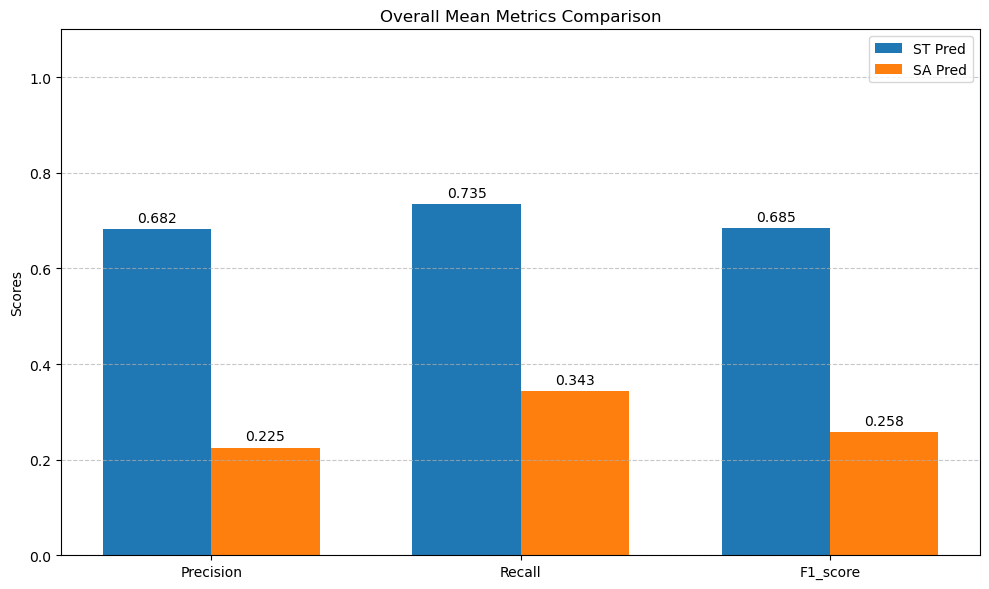

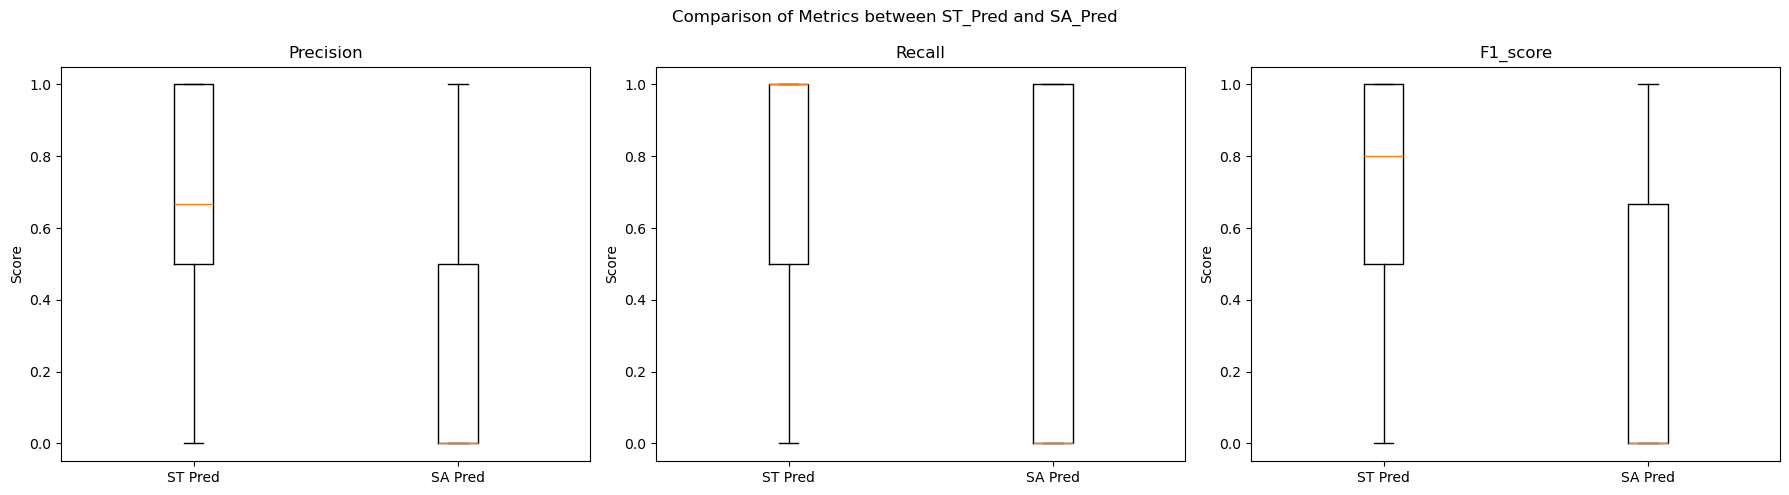

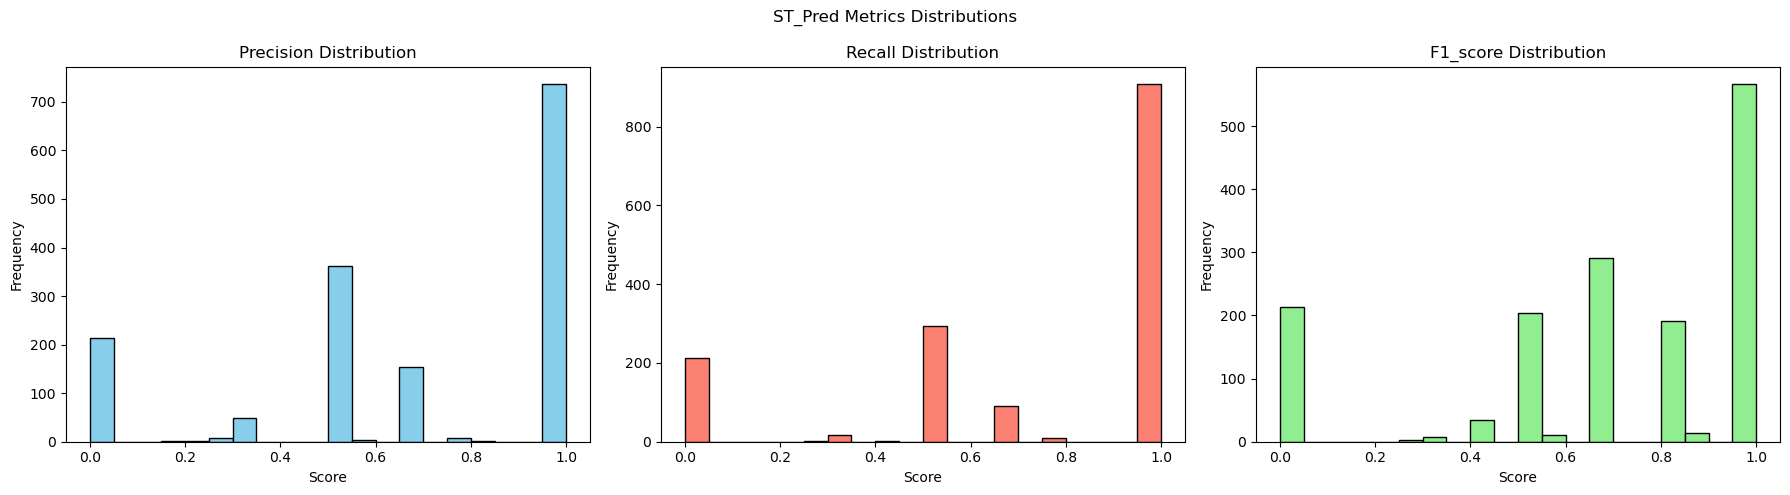

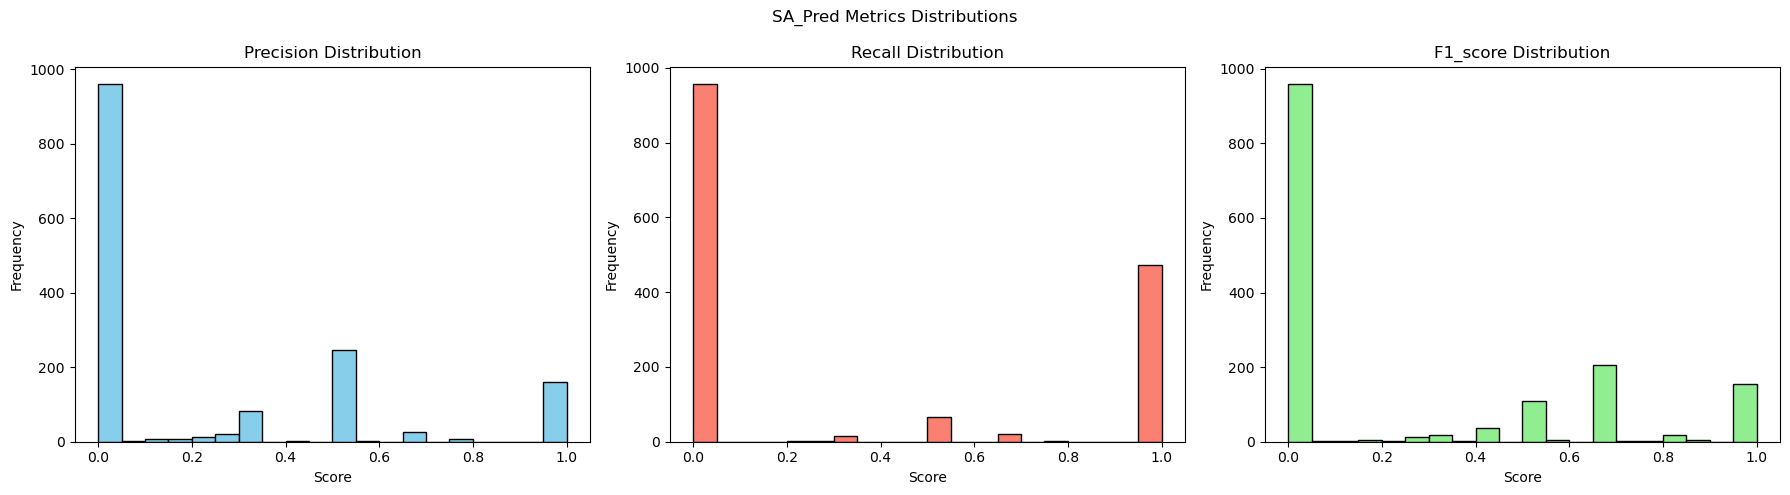

In [ ]:
import warnings
warnings.filterwarnings('ignore')  # Turn off all warnings

# Function to safely convert string to dict
def parse_dict_string(s):
    try:
        return ast.literal_eval(s)
    except:
        return {}

# Parse the dictionary columns
df['eval_ST_Pred_dict'] = df['eval_ST_Pred'].apply(parse_dict_string)
df['eval_SA_Pred_dict'] = df['eval_SA_Pred'].apply(parse_dict_string)

# Extract metrics
def extract_metrics(metric_dict):
    if not metric_dict:
        return {'precision': np.nan, 'recall': np.nan, 'f1_score': np.nan}
    return {
        'precision': metric_dict.get('precision', np.nan),
        'recall': metric_dict.get('recall', np.nan),
        'f1_score': metric_dict.get('f1_score', np.nan)
    }

# Create DataFrames for each evaluation type
st_metrics = pd.DataFrame(df['eval_ST_Pred_dict'].apply(extract_metrics).tolist())
sa_metrics = pd.DataFrame(df['eval_SA_Pred_dict'].apply(extract_metrics).tolist())

# NEW: Calculate overall means
st_means = st_metrics.mean()
sa_means = sa_metrics.mean()

# NEW: Plotting function for overall metrics
def plot_overall_metrics(st_means, sa_means):
    metrics = ['precision', 'recall', 'f1_score']
    x = np.arange(len(metrics))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    rects1 = ax.bar(x - width/2, st_means, width, label='ST Pred', color='#1f77b4')
    rects2 = ax.bar(x + width/2, sa_means, width, label='SA Pred', color='#ff7f0e')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Overall Mean Metrics Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels([m.capitalize() for m in metrics])
    ax.legend()
    ax.set_ylim(0, 1.1)
    
    # Add value labels on top of bars
    for rects in [rects1, rects2]:
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plotting function for metrics comparison (your existing)
def plot_metrics_comparison(st_metrics, sa_metrics):
    metrics = ['precision', 'recall', 'f1_score']
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        ax.boxplot([st_metrics[metric].dropna(), sa_metrics[metric].dropna()], 
                   labels=['ST Pred', 'SA Pred'])
        ax.set_title(metric.capitalize())
        ax.set_ylabel('Score')
    
    plt.suptitle('Comparison of Metrics between ST_Pred and SA_Pred')
    plt.tight_layout()
    plt.show()

# Plotting function for distributions (your existing)
def plot_metric_distributions(metrics, title):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    colors = ['skyblue', 'salmon', 'lightgreen']
    
    for i, (metric, color) in enumerate(zip(['precision', 'recall', 'f1_score'], colors)):
        ax = axes[i]
        ax.hist(metrics[metric].dropna(), bins=20, color=color, edgecolor='black')
        ax.set_title(f'{metric.capitalize()} Distribution')
        ax.set_xlabel('Score')
        ax.set_ylabel('Frequency')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Generate all plots
plot_overall_metrics(st_means, sa_means)  # NEW: Overall means plot
plot_metrics_comparison(st_metrics, sa_metrics)
plot_metric_distributions(st_metrics, 'ST_Pred Metrics Distributions')
plot_metric_distributions(sa_metrics, 'SA_Pred Metrics Distributions')

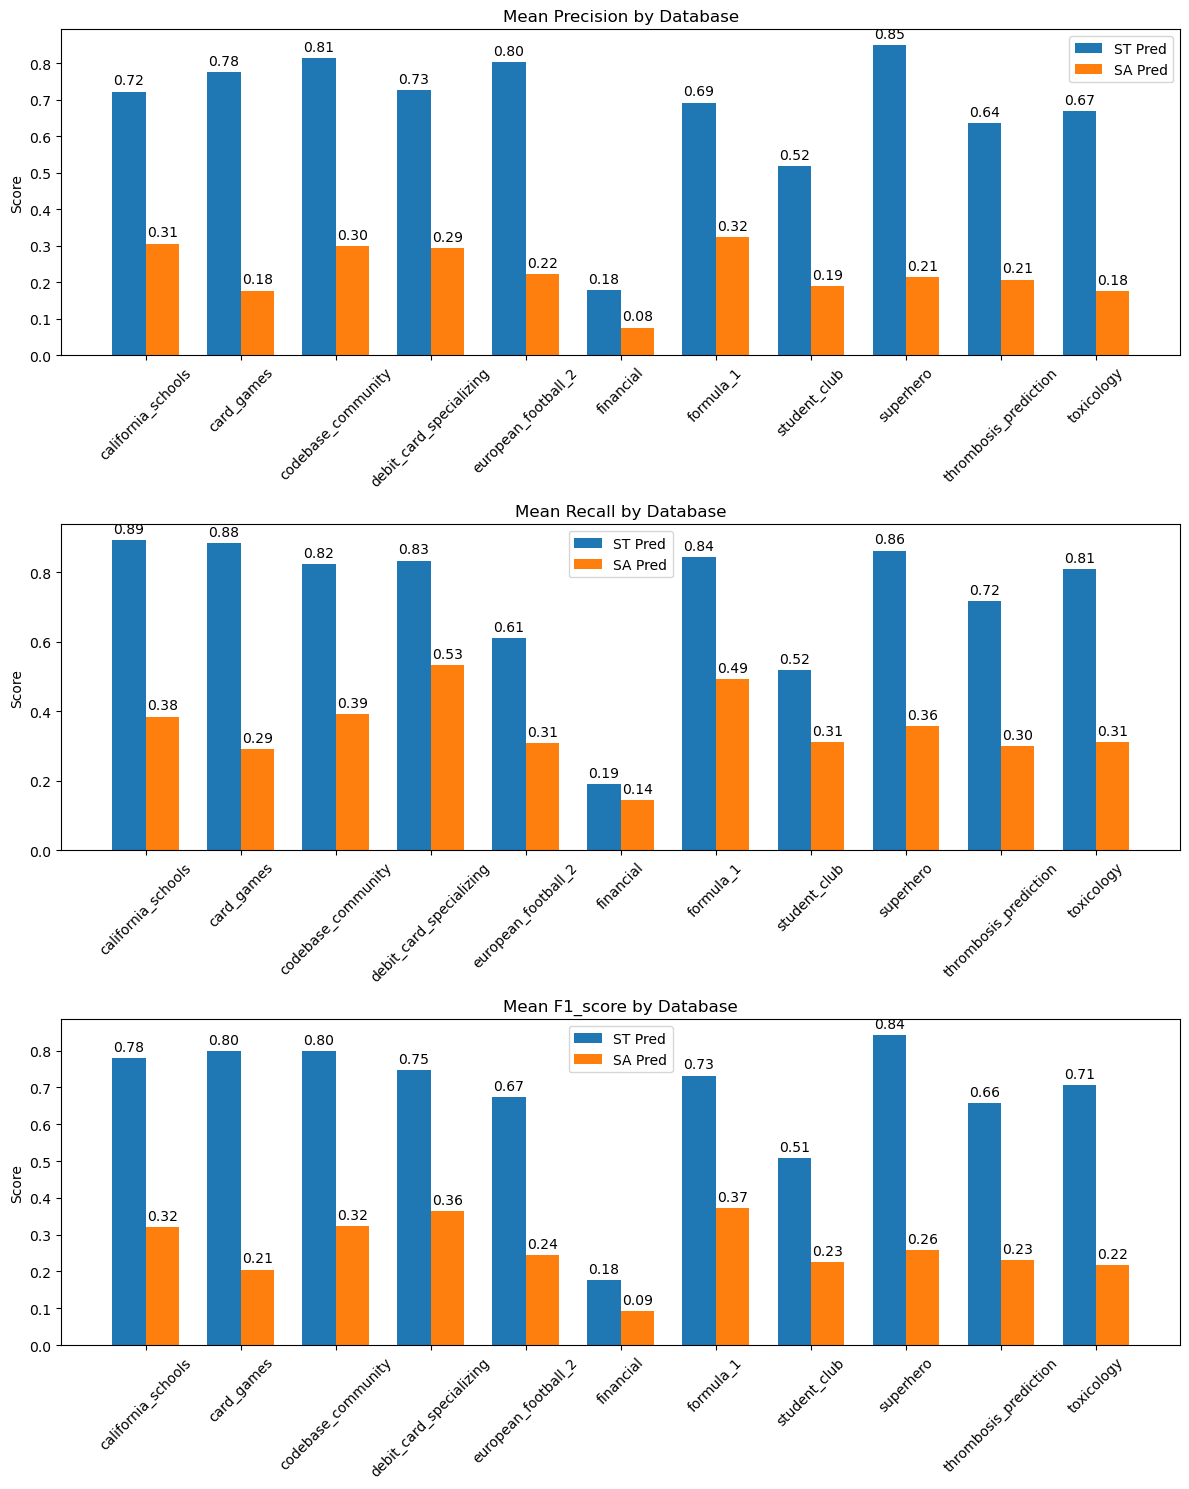


Mean Metrics by Database:
                  db_id  ST_precision  ST_recall  ST_f1_score  SA_precision  SA_recall  SA_f1_score
     california_schools      0.722846   0.893258     0.780899      0.306074   0.384270     0.320715
             card_games      0.776614   0.883944     0.799327      0.176961   0.289703     0.205349
     codebase_community      0.814516   0.824373     0.800026      0.298746   0.391577     0.322350
debit_card_specializing      0.727865   0.833333     0.746354      0.292969   0.533854     0.364063
    european_football_2      0.803618   0.611111     0.673385      0.221697   0.307494     0.244028
              financial      0.178953   0.189465     0.175756      0.075472   0.143082     0.092633
              formula_1      0.692529   0.844253     0.732521      0.324425   0.491379     0.372373
           student_club      0.517616   0.517405     0.508590      0.190313   0.311181     0.225352
              superhero      0.851163   0.862403     0.843054      0.2144

In [ ]:
# Create metrics DataFrames
df['ST_metrics'] = df['eval_ST_Pred_dict'].apply(extract_metrics)
df['SA_metrics'] = df['eval_SA_Pred_dict'].apply(extract_metrics)

# Expand the metrics into separate columns
st_expanded = pd.json_normalize(df['ST_metrics']).add_prefix('ST_')
sa_expanded = pd.json_normalize(df['SA_metrics']).add_prefix('SA_')
df = pd.concat([df, st_expanded, sa_expanded], axis=1)

# Group by db_id and calculate means
grouped = df.groupby('db_id').agg({
    'ST_precision': 'mean',
    'ST_recall': 'mean',
    'ST_f1_score': 'mean',
    'SA_precision': 'mean',
    'SA_recall': 'mean',
    'SA_f1_score': 'mean'
}).reset_index()

# Plotting function for mean metrics by db_id
def plot_mean_metrics_by_db(grouped):
    metrics = ['precision', 'recall', 'f1_score']
    n_db = len(grouped)
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # Positions for bars
        x = np.arange(n_db)
        width = 0.35
        
        # Plot ST and SA metrics
        st_bars = ax.bar(x - width/2, grouped[f'ST_{metric}'], width, label='ST Pred')
        sa_bars = ax.bar(x + width/2, grouped[f'SA_{metric}'], width, label='SA Pred')
        
        ax.set_title(f'Mean {metric.capitalize()} by Database')
        ax.set_ylabel('Score')
        ax.set_xticks(x)
        ax.set_xticklabels(grouped['db_id'], rotation=45)
        ax.legend()
        
        # Add value labels
        for bar in st_bars + sa_bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords="offset points",
                         ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Generate the plot
plot_mean_metrics_by_db(grouped)

# Optional: Also show the numerical table
print("\nMean Metrics by Database:")
print(grouped.to_string(index=False))

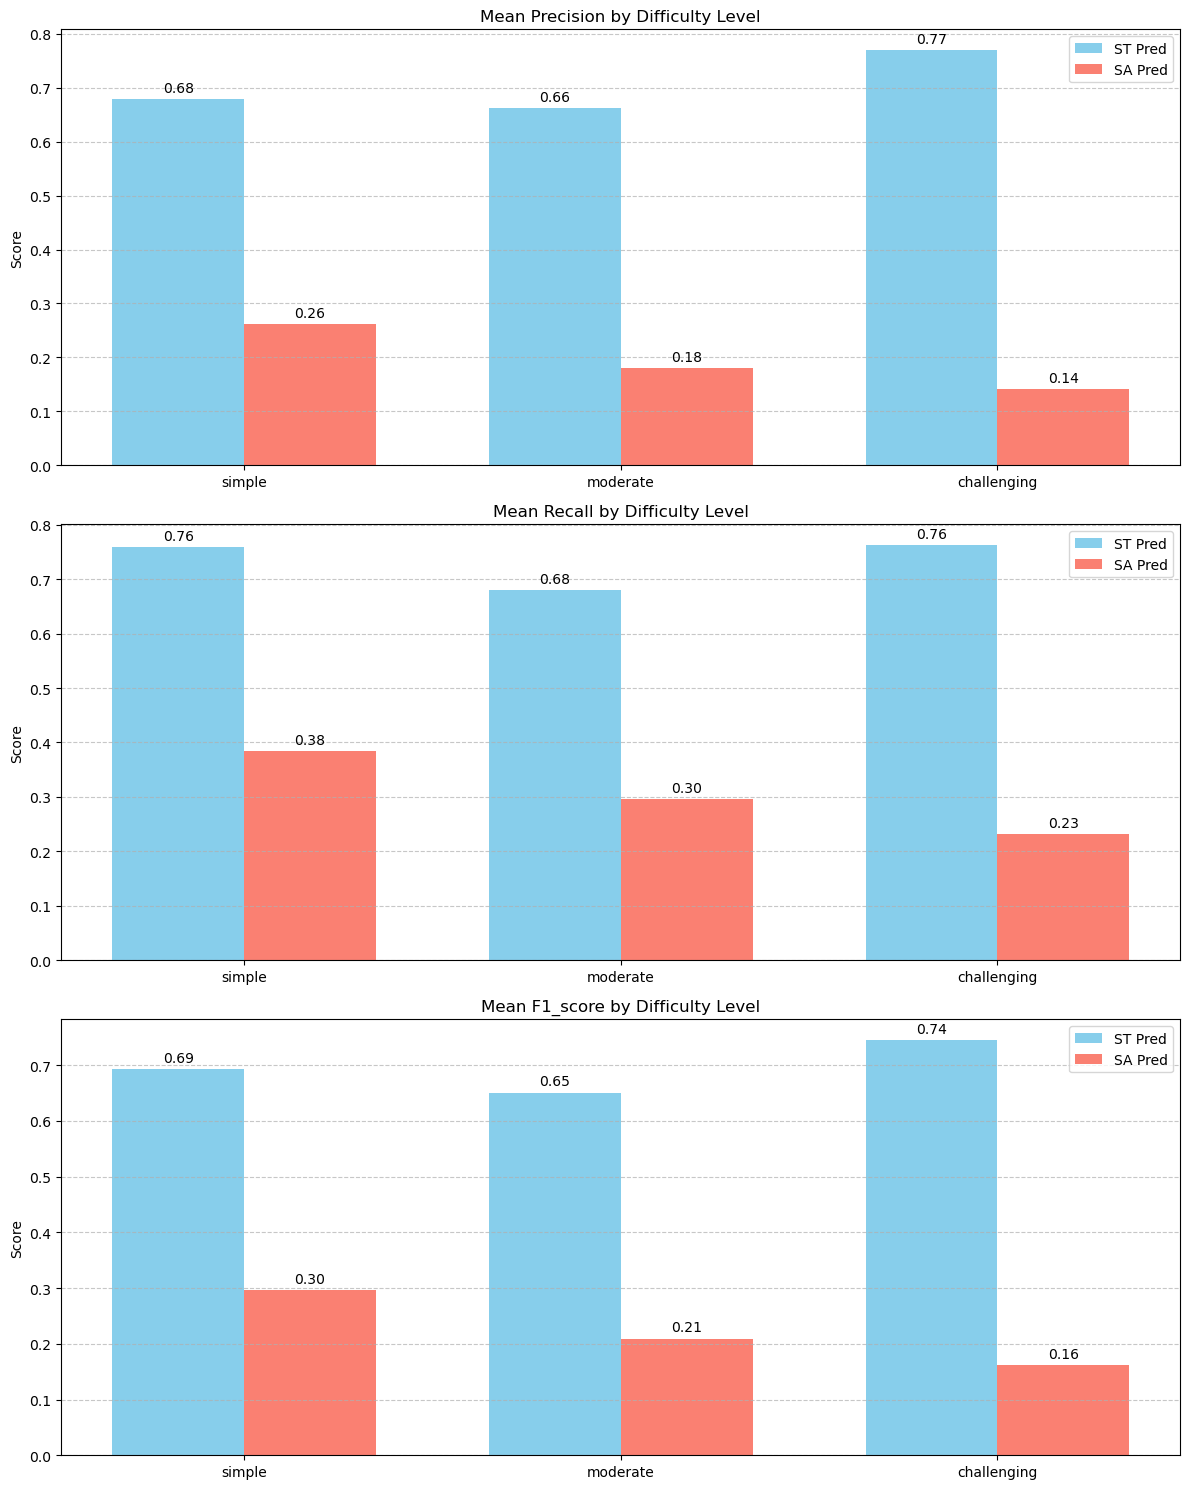


Mean Metrics by Difficulty Level:
 difficulty  ST_precision  ST_recall  ST_f1_score  SA_precision  SA_recall  SA_f1_score
     simple      0.678237   0.758919     0.692295      0.261328   0.383964     0.296950
   moderate      0.662177   0.679418     0.650876      0.179446   0.295510     0.209400
challenging      0.769655   0.762529     0.744970      0.141570   0.231034     0.162129


In [ ]:
# Sort by difficulty if it's ordinal (customize order as needed)
if df['difficulty'].dtype == 'object':
    # If difficulty has known levels, specify the desired order
    difficulty_order = ['simple', 'moderate', 'challenging']  # Modify as needed
    grouped['difficulty'] = pd.Categorical(grouped['difficulty'], categories=difficulty_order, ordered=True)
    grouped = grouped.sort_values('difficulty')

# Plotting function for mean metrics by difficulty
def plot_mean_metrics_by_difficulty(grouped):
    metrics = ['precision', 'recall', 'f1_score']
    n_levels = len(grouped)
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # Positions for bars
        x = np.arange(n_levels)
        width = 0.35
        
        # Plot ST and SA metrics
        st_bars = ax.bar(x - width/2, grouped[f'ST_{metric}'], width, label='ST Pred', color='skyblue')
        sa_bars = ax.bar(x + width/2, grouped[f'SA_{metric}'], width, label='SA Pred', color='salmon')
        
        ax.set_title(f'Mean {metric.capitalize()} by Difficulty Level')
        ax.set_ylabel('Score')
        ax.set_xticks(x)
        ax.set_xticklabels(grouped['difficulty'])
        ax.legend()
        
        # Add value labels
        for bar in st_bars + sa_bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')
        
        # Add a horizontal grid
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Generate the plot
plot_mean_metrics_by_difficulty(grouped)

# Optional: Also show the numerical table
print("\nMean Metrics by Difficulty Level:")
print(grouped.to_string(index=False))